# Bike Sharing Forecasting

Bicycle sharing is a popular shared transport service that provides bicycles to individuals for short-term use. These systems typically provide bike docks where riders can borrow a bike and return it to any dock belonging to the same system. The docks are equipped with special bike racks that secure the bike and only release it via computer control.

One of the major challenges faced by operators of these systems is the need to redistribute bikes to ensure that there are bikes available at all docks, as well as free spaces for returns.

In order to improve the planning and execution of bicycle distribution, it is proposed to create a model capable of forecasting the number of users over the next 36 hours. In this way, at 12:00 every day, the company in charge of managing the system will be able to know the expected demand for the rest of the day (12 hours) and the next day (24 hours).

For illustrative purposes, the current example only models a single station, but the predictive model can be adapted and extended to cover multiple stations, thereby improving the management of bike-sharing systems on a larger scale.

## Libraries

In [1]:

# Data Processing
# -------------------------------------------------------
import numpy as np
import pandas as pd
import datetime


# Visulization
# -------------------------------------------------------
from matplotlib import pyplot
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import plotly.express as px

# Modelling and Forecasting
# -------------------------------------------------------
## ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller #check for Stationarity
## XGBoost
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

# Configuration warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data
The data in this document represent the hourly usage of the bike share system in the city of Washington, D.C. during the years 2011 and 2012. In addition to the number of users per hour, information about weather conditions and holidays is available. The original data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) and has been previously cleaned ([code](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/blob/master/code/prepare_bike_sharing_dataset.ipynb)) applying the following modifications:

- Renamed columns with more descriptive names.
- Renamed categories of the weather variables. The category of heavy_rain has been combined with that of rain.
- Denormalized temperature, humidity and wind variables.
- date_time variable created and set as index.
- Imputed missing values by forward filling.
- The resulting data set contains the columns:
- date_time: date and time.
- month: month (1 to 12).
- hour: hour (0 to 23).
- holiday: whether or not the day is a holiday (taken from http://dchr.dc.gov/page/holiday-schedule).
- weekday: day of the week (Monday = 0, Sunday = 6).
- workingday : if it is a working day.
- weather: the weather of the day (clear, mist, rain).
- temp: recorded temperature.
- atemp: thermal sensation.
- hum: recorded humidity.
- windspeed: recorded wind speed.
- users: total number of users of the bike rental service.

In [2]:
df_hour = pd.read_csv("data_bikesharing/hour.csv")
df_hour.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [3]:
df_day = pd.read_csv("data_bikesharing/day.csv")
df_day.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


In [4]:
# Rename the columns with more descriptive names
df_hour = df_hour.rename(
            columns={
                'dteday': 'date_time',
                'yr': 'year',
                'mnth': 'month',
                'hr': 'hour',
                'weathersit': 'weather',
                'cnt': 'users'
            })

# The levels of the weather variable are renamed. There are only four values
# of heavy rain, so they are considered as rain.
df_hour['weather'] = df_hour['weather'].replace({
                                        1: 'clear',
                                        2: 'mist',
                                        3: 'rain',
                                        4: 'rain' 
                                    })

# The temperature, humidity and wind are denormalized
df_hour['temp'] = df_hour['temp'] * 41
df_hour['atemp'] = df_hour['atemp'] * 50
df_hour['hum'] = df_hour['hum'] * 100
df_hour['windspeed'] = df_hour['windspeed'] * 67 

# Join the date and time, and set as an index
df_hour['date_time'] = df_hour.apply(
                        lambda row: f"{row['date_time']} {str(row['hour']).zfill(2)}:00:00",
                        axis = 1
                     )
df_hour['date_time'] = pd.to_datetime(df_hour['date_time'], format='%Y-%m-%d %H:%M:%S')
df_hour = df_hour.set_index('date_time')
df_hour = df_hour.asfreq('H')
df_hour = df_hour.sort_index() 

df_hour = df_hour.drop(columns=['instant', 'season', 'year', 'month', 'hour',
                            'weekday', 'casual', 'registered'])

In [5]:
# Rename the columns with more descriptive names
df_day = df_day.rename(
            columns={
                'dteday': 'date_time',
                'yr': 'year',
                'mnth': 'month',
                'hr': 'hour',
                'weathersit': 'weather',
                'cnt': 'users'
            })

# The levels of the weather variable are renamed. There are only four values
# of heavy rain, so they are considered as rain.
df_day['weather'] = df_day['weather'].replace({
                                        1: 'clear',
                                        2: 'mist',
                                        3: 'rain',
                                        4: 'rain' 
                                    })

# The temperature, humidity and wind are denormalized
df_day['temp'] = df_day['temp'] * 41
df_day['atemp'] = df_day['atemp'] * 50
df_day['hum'] = df_day['hum'] * 100
df_day['windspeed'] = df_day['windspeed'] * 67 

# Join the date and time, and set as an index
df_day['date_time'] = df_day.apply(
                        lambda row: f"{row['date_time']}",
                        axis = 1
                     )
df_day['date_time'] = pd.to_datetime(df_day['date_time'], format='%Y-%m-%d')
df_day = df_day.set_index('date_time')
df_day = df_day.asfreq('D')
df_day = df_day.sort_index() 

df_day = df_day.drop(columns=['instant', 'season', 'year', 'month',
                            'weekday', 'casual', 'registered'])
df_day.head(3)

,holiday,workingday,weather,temp,atemp,hum,windspeed,users
date_time,,,,,,,,
2011-01-01,0,0,mist,14.110847,18.18125,80.5833,10.749882,985
2011-01-02,0,0,mist,14.902598,17.68695,69.6087,16.652113,801
2011-01-03,0,1,clear,8.050924,9.47025,43.7273,16.636703,1349


In [160]:
df_month = df_day.resample("M").sum()
df_month.head(3)


,holiday,workingday,temp,atemp,hum,windspeed,users,month,weekday
date_time,,,,,,,,,
2011-01-31,1,20,251.285203,316.958835,1811.5357,405.884848,38189,31,95
2011-02-28,1,19,324.356002,398.177350,1568.2607,428.793655,48215,56,84
2011-03-31,0,23,421.548224,504.213700,1765.1829,482.710947,64045,93,90


In [6]:
# check whether the temporary index is complete
(df_hour.index == pd.date_range(start=df_hour.index.min(),
                              end=df_hour.index.max(),
                              freq=df_hour.index.freq)).all()

True

In [7]:
# check whether the temporary index is complete
(df_day.index == pd.date_range(start=df_day.index.min(),
                              end=df_day.index.max(),
                              freq=df_day.index.freq)).all()

True

In [8]:
# check missing data of df_hour
n_missing = len(df_hour[df_hour.isnull().any(axis=1)])
print(f"Missing data number: {n_missing} ({100 * n_missing / len(df_hour):.2f}%)")

# check missing data
n_missing = len(df_day[df_day.isnull().any(axis=1)])
print(f"Missing data number: {n_missing} ({100 * n_missing / len(df_day):.2f}%)")

Missing data number: 165 (0.94%)
Missing data number: 0 (0.00%)


There is a total of 165 hours for which no information is available. The time series has to be complete in order to apply the forcasting strategies available in the skforecast library. In this case, since the missing values are very few and widely scattered, forward fill is used as the imputation strategy. There are other strategies that might give better results.

In [9]:
df_hour = df_hour.fillna(method='ffill')


Once the missing values have been imputed, the variables month, hour and day of the week are recalculated.

In [10]:
df_hour['month'] = df_hour.index.month 
df_hour['hour'] = df_hour.index.hour
df_hour['weekday'] = df_hour.index.weekday # Monday = 0, Sunday = 6
print(f"data start:{df_hour.index.min()}, end:{df_hour.index.max()}")
print(df_hour.head(3))
df_day['month'] = df_day.index.month 
df_day['weekday'] = df_day.index.weekday # Monday = 0, Sunday = 6
print(f"data start:{df_day.index.min()}, end:{df_day.index.max()}")
print(df_day.head(3))

data start:2011-01-01 00:00:00, end:2012-12-31 23:00:00
                     holiday  workingday weather  temp   atemp   hum  \
date_time                                                              
2011-01-01 00:00:00      0.0         0.0   clear  9.84  14.395  81.0   
2011-01-01 01:00:00      0.0         0.0   clear  9.02  13.635  80.0   
2011-01-01 02:00:00      0.0         0.0   clear  9.02  13.635  80.0   

                     windspeed  users  month  hour  weekday  
date_time                                                    
2011-01-01 00:00:00        0.0   16.0      1     0        5  
2011-01-01 01:00:00        0.0   40.0      1     1        5  
2011-01-01 02:00:00        0.0   32.0      1     2        5  
data start:2011-01-01 00:00:00, end:2012-12-31 00:00:00
            holiday  workingday weather       temp     atemp      hum  \
date_time                                                               
2011-01-01        0           0    mist  14.110847  18.18125  80.5833  

In [11]:
df_hour.to_csv("data_bikesharing/bike_sharing_dataset_clean_hour.csv")
df_day.to_csv("data_bikesharing/bike_sharing_dataset_clean_day.csv")

In [12]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train_hour = df_hour.loc[: end_train, :]
data_val_hour   = df_hour.loc[end_train:end_validation, :]
data_test_hour  = df_hour.loc[end_validation:, :]

print(f"Dates train      : {data_train_hour.index.min()} --- {data_train_hour.index.max()}  (n={len(data_train_hour)})")
print(f"Dates validacion : {data_val_hour.index.min()} --- {data_val_hour.index.max()}  (n={len(data_val_hour)})")
print(f"Dates test       : {data_test_hour.index.min()} --- {data_test_hour.index.max()}  (n={len(data_test_hour)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


In [13]:
# Split train-validation-test
# ==============================================================================
data_train_day = df_day.loc[: end_train, :]
data_val_day   = df_day.loc[end_train: end_validation, :]
data_test_day  = df_day.loc[end_validation:, :]

print(f"Dates train      : {data_train_day.index.min()} --- {data_train_day.index.max()}  (n={len(data_train_day)})")
print(f"Dates validacion : {data_val_day.index.min()} --- {data_val_day.index.max()}  (n={len(data_val_day)})")
print(f"Dates test       : {data_test_day.index.min()} --- {data_test_day.index.max()}  (n={len(data_test_day)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 00:00:00  (n=456)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 00:00:00  (n=153)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 00:00:00  (n=122)


In [45]:
index_future_dates_hour = pd.date_range(start = '2013-01-01 00:00:00', 
                                   end = '2013-06-30 23:00:00',
                                   freq = 'H')
print(f"index_future_dates:\n {index_future_dates_hour}")

index_future_dates_day = pd.date_range(start = '2013-01-01 00:00:00', 
                                   end = '2013-06-30 00:00:00',
                                   freq = 'D')
print(f"index_future_dates:\n {index_future_dates_day}")

index_future_dates:
 DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2013-06-30 14:00:00', '2013-06-30 15:00:00',
               '2013-06-30 16:00:00', '2013-06-30 17:00:00',
               '2013-06-30 18:00:00', '2013-06-30 19:00:00',
               '2013-06-30 20:00:00', '2013-06-30 21:00:00',
               '2013-06-30 22:00:00', '2013-06-30 23:00:00'],
              dtype='datetime64[ns]', length=4344, freq='H')
index_future_dates:
 DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2013-06-21', '2013-06-22', '2013-06-23', '2013-

## Preditvie Technologies
Problem: predict how many days in the office from 2011-01-01 00:00:00 to 2012-12-31 23:00:00
- Statistical model: 
    - ARIMA(AutoRegressive Integrated Moving Average), SARIMA (Seasonal ARIMA), 
        - [YouTube](https://www.youtube.com/watch?v=8FCDpFhd1zk)
        - [Time Series Analysis Using ARIMA From Statsmodels](https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/)
        - [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning#Tuning-the-hyperparameters)
- Regression Algorithm: 
    - XGBoost
        - [How to Select a Model For Your Time Series Prediction Task [Guide]](https://neptune.ai/blog/select-model-for-time-series-prediction-task)
        - [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM, Scikit-learn y CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost)


###  Statistical Model - ARIMA & SARIMA

### Data exploration

In [15]:
data_arima = df_day.copy()
data_arima_train = pd.concat([data_train_day, data_val_day])
data_arima_test = data_test_day.copy()

In [16]:
def plot_data(data, title, xlabel, ylabel):
    plt.style.use('bmh')
    data.plot(figsize=(12,3))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

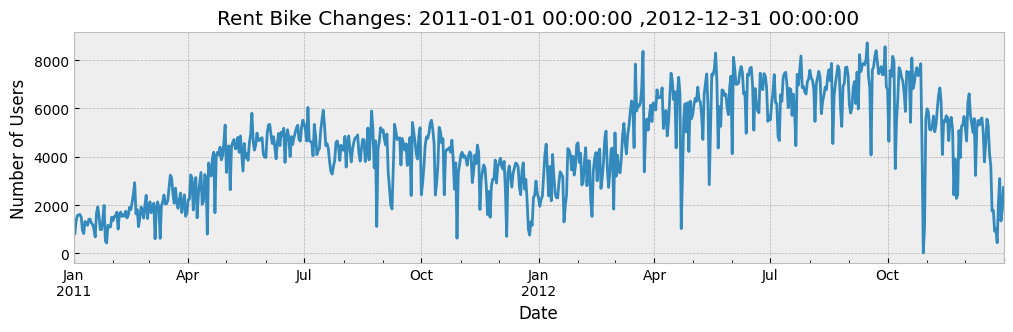

In [17]:
# plot the data
plot_data(data = data_arima['users'],
          title = f'Rent Bike Changes: {data_arima.index.min()} ,{data_arima.index.max()}',
          xlabel = 'Date',
          ylabel = 'Number of Users')
# data_model.info()

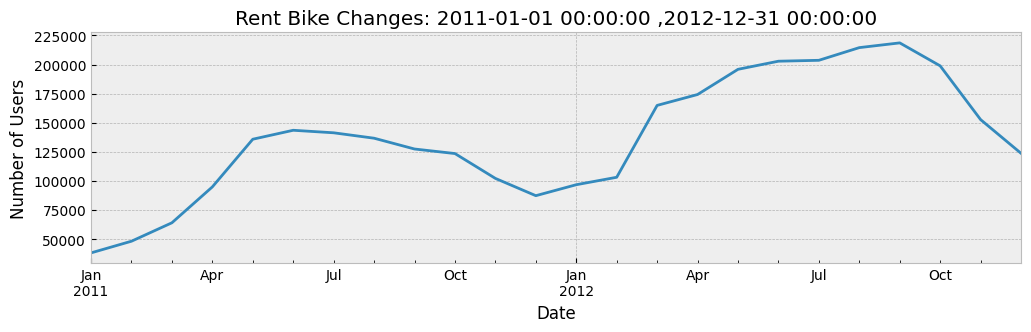

In [161]:
# plot the data
plot_data(data = df_month['users'],
          title = f'Rent Bike Changes: {data_arima.index.min()} ,{data_arima.index.max()}',
          xlabel = 'Date',
          ylabel = 'Number of Users')
# data_model.info()

##### Decompose the Data
to decompose the data to view more of the complexity behind the linear visualization.<br> A useful Python function called seasonal_decompose within the 'statsmodels' package can help us to decompose the data into four different components:
- Observed
- Trended:<br>
    - represents the long-term, non-seasonal changes in the data.
    - captures the overall direction and pattern of the time series.<br> It can be increasing, decreasing, or stationary.
- Seasonal:<br>
    - represents the repeating patterns or fluctuations that occur within a specific time period.
    - captures the regular and predictable variations in the data that repeat at fixed intervals. <br>For example, monthly sales data may exhibit seasonality with higher sales during certain months.
- Residual:<br>
    - represents the random or irregular fluctuations that cannot be explained by the trend or seasonality.
    - captures the unexplained part of the time series after removing the trend and seasonality components. 
    - often considered as noise or random variability.

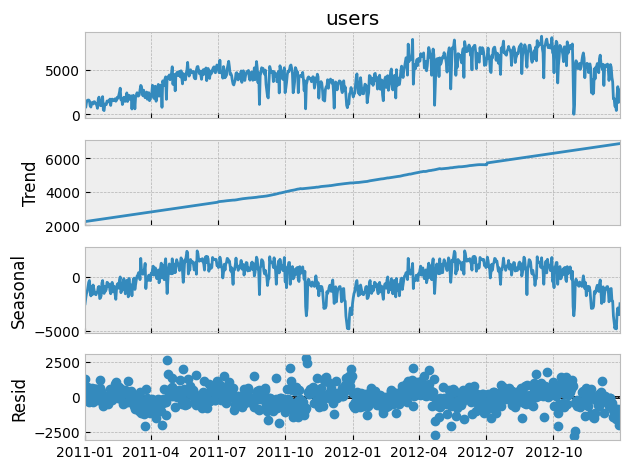

In [18]:
# graphs to show seasonal_decompose
def seasonal_decompose (Y):
    decomposition = sm.tsa.seasonal_decompose(x=Y, model='additive', extrapolate_trend='freq', period=int(len(Y)/2))
    decomposition.plot()
    plt.show()
seasonal_decompose(data_arima['users'])

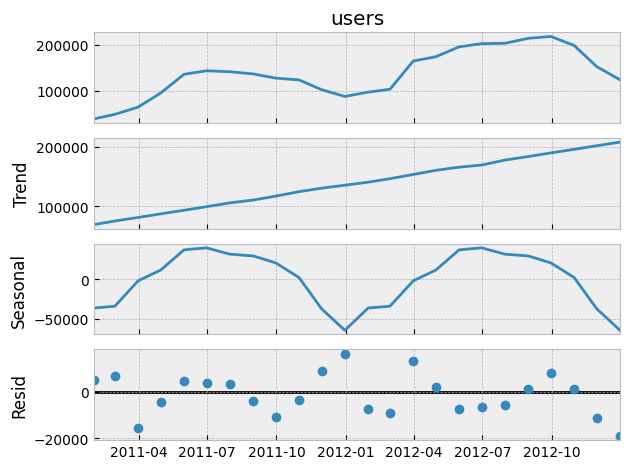

In [162]:
seasonal_decompose(df_month['users'])

##### Auto Regressive Model
- Partial Auto Correlation Function - Takes in to account the impact of direct variables only
- Auto Correlation Function - Takes in to account the impact of all the variables (direct + indirect) <br>
Let us plot lags on the horizontal and the correlations on vertical axis using plot_acf and plot_pacf function. <br>
In the graphs below, each spike(lag) which is above the dashed area considers to be statistically significant.

In [165]:
def plot_acf_pacf(data, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data,lags=lags,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data,lags=lags,ax=ax2)

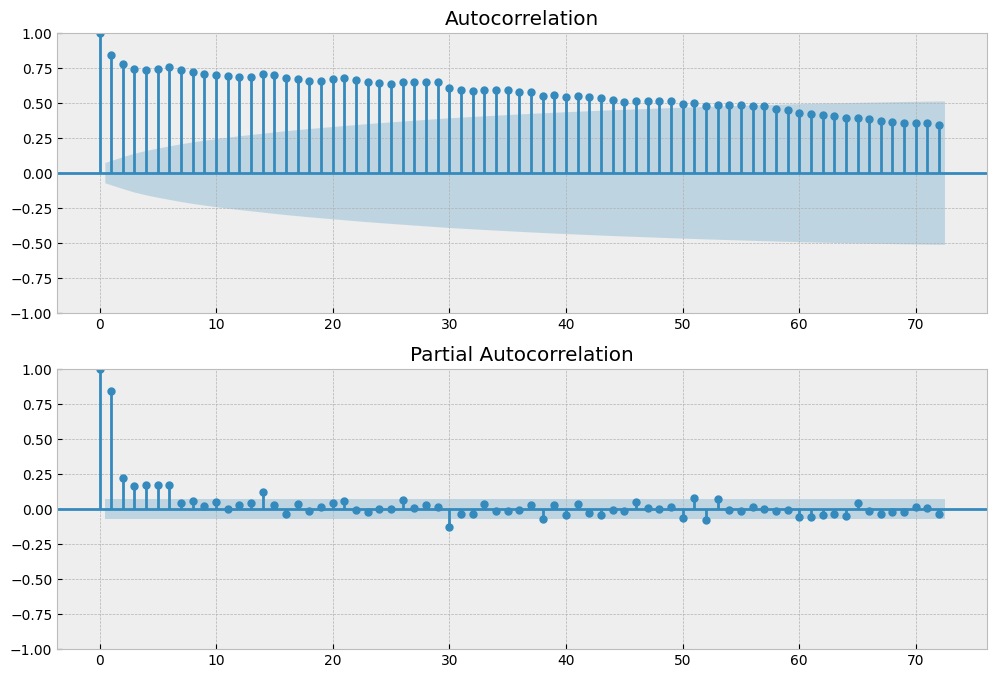

In [166]:
plot_acf_pacf(data_arima['users'], 72)

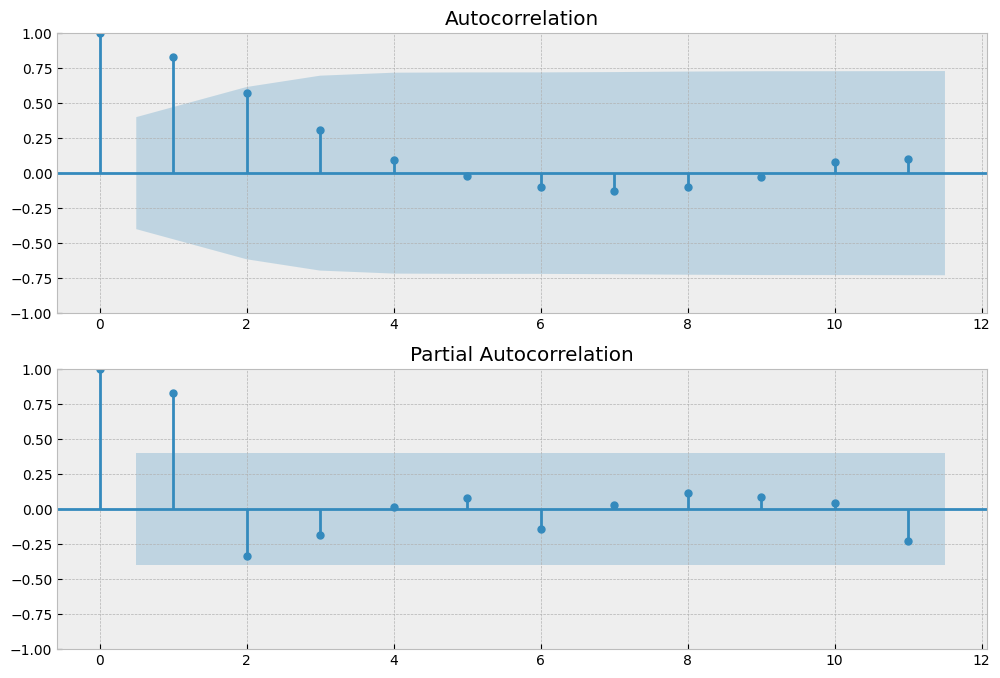

In [174]:
plot_acf_pacf(df_month['users'], 11)

##### check for Stationarity


Augmented Dickey-Fuller (ADF) test
- determine the presence of unit roots in a time series.
- helps to assess whether a time series is stationary or non-stationary
- a stationary time series has constant mean, variance, and autocovariance over time, making it easier to analyze and model.
- a non-stationary time series exhibits trends, seasonality, or other changing statistical properties, which can make modeling and forecasting more challenging.

ADF
- assess the strength of evidence against the null hypothesis. 
- It is a negative number and the more negative it is, the stronger the evidence for rejecting the null hypothesis of non-stationarity.

P-value
- represents the probability of observing the test statistic under the null hypothesis.
- A small p-value (e.g., less than 0.05) suggests strong evidence against the null hypothesis and indicates that the time series is stationary. 
- Conversely, a large p-value indicates weak evidence against the null hypothesis and suggests non-stationarity.

Critical value
- determine the threshold for rejecting the null hypothesis. 
- They are pre-defined values at different confidence levels (e.g., 1%, 5%, and 10%) that provide a cut-off point for the test statistic. 
- If the test statistic is more negative than the critical value, the null hypothesis is rejected.



In [21]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print(f"1. ADF: {dftest[0]}")
    print(f"2. P-Value: {dftest[1]}")
    if dftest[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")
    print(f"3. Num of Lags: {dftest[2]}")
    print(f"4. Num of Observation Used for ADF Regression and Critical Values Calculation: {dftest[3]}")
    print(f"5. Critical Values:")
    for key , val in dftest[4].items():
        print("\t",key, ": ", val)

In [22]:
ad_test(data_arima['users'])


1. ADF: -1.8774481444374282
2. P-Value: 0.3427434403392201
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 
3. Num of Lags: 13
4. Num of Observation Used for ADF Regression and Critical Values Calculation: 717
5. Critical Values:
	 1% :  -3.439503230053971
	 5% :  -2.8655794463678346
	 10% :  -2.5689210707289982


In [175]:
ad_test(df_month['users'])

1. ADF: 0.3491580615135268
2. P-Value: 0.979490770278382
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 
3. Num of Lags: 9
4. Num of Observation Used for ADF Regression and Critical Values Calculation: 14
5. Critical Values:
	 1% :  -4.01203360058309
	 5% :  -3.1041838775510207
	 10% :  -2.6909873469387753


##### Differencing
Differencing helps remove the changes from the data and make data stationary

In [23]:
data_arima['First Difference'] = data_arima['users'] - data_arima['users'].shift(1)
data_arima.head(5)

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,weekday,First Difference
date_time,,,,,,,,,,,
2011-01-01,0,0,mist,14.110847,18.18125,80.5833,10.749882,985,1,5,NaN
2011-01-02,0,0,mist,14.902598,17.68695,69.6087,16.652113,801,1,6,-184.0
2011-01-03,0,1,clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,548.0
2011-01-04,0,1,clear,8.200000,10.60610,59.0435,10.739832,1562,1,1,213.0
2011-01-05,0,1,clear,9.305237,11.46350,43.6957,12.522300,1600,1,2,38.0


##### check if the data now is stationary

1. ADF: -11.778809074151859
2. P-Value: 1.0467797548020943e-21
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary
3. Num of Lags: 12
4. Num of Observation Used for ADF Regression and Critical Values Calculation: 717
5. Critical Values:
	 1% :  -3.439503230053971
	 5% :  -2.8655794463678346
	 10% :  -2.5689210707289982


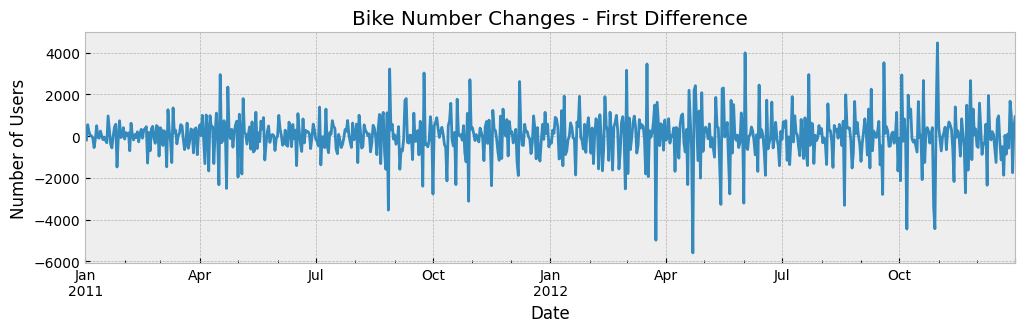

In [24]:
ad_test(data_arima['First Difference'].dropna())
# plot the data
plot_data(data=data_arima['First Difference'],
          title='Bike Number Changes - First Difference',
          xlabel='Date',
          ylabel='Number of Users')

##### Figure Out Order for ARIMA Model

In [25]:
stepwise_fit = auto_arima(data_arima['users'],
                          trace=True,
                          suppress_warnings=True,
                          )
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12056.106, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12252.265, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12189.627, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12112.006, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12250.270, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12053.607, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12057.516, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12051.878, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12052.925, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12158.388, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12050.020, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12110.027, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12187.633, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12051.049, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0

In [176]:
stepwise_fit = auto_arima(df_month['users'],
                          trace=True,
                          suppress_warnings=True,
                          )
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=530.133, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=530.092, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=524.884, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=527.312, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=528.737, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=526.539, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=526.712, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=528.321, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=522.884, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=524.565, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=524.662, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=525.522, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=526.296, Time=0.37 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.222 seconds
                               SARI

##### Train the  Model - ARIMA
- ARIMA order (p, d, q)
    - p: the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors.
    - d: the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.
    - q: the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

In [223]:
model = ARIMA(data_arima_train['users'].astype(float),
              order=(1, 1, 1),
              )
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  users   No. Observations:                  609
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4960.854
Date:                Wed, 05 Jul 2023   AIC                           9927.707
Time:                        17:42:28   BIC                           9940.938
Sample:                    01-01-2011   HQIC                          9932.855
                         - 08-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2786      0.043      6.412      0.000       0.193       0.364
ma.L1         -0.8911      0.019    -46.988      0.000      -0.928      -0.854
sigma2      7.142e+05   2.44e+04     29.321      0.0

In [224]:
def plot_res(residuals, title, xlabel, ylabel):
    plot_data(data= residuals,
            title= title,
            xlabel= xlabel,
            ylabel= ylabel)
    # density plot of residuals
    residuals.plot(kind='kde')
    pyplot.show()
    # summary stats of residuals
    print(residuals.describe())
    print(f"Root Mean Square Error:{np.sqrt(np.mean(residuals**2))}")

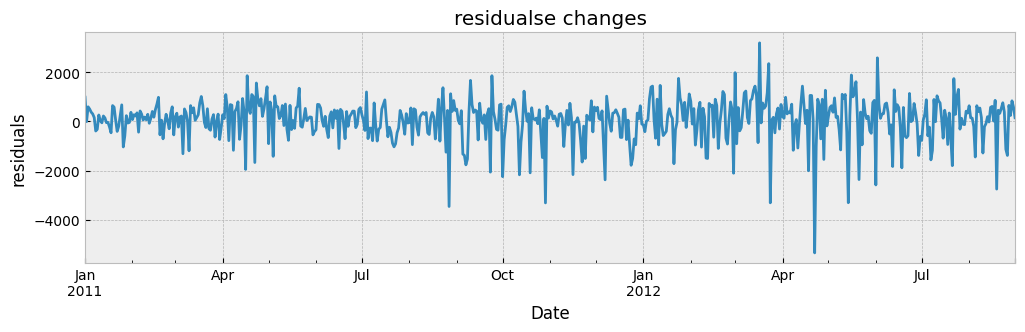

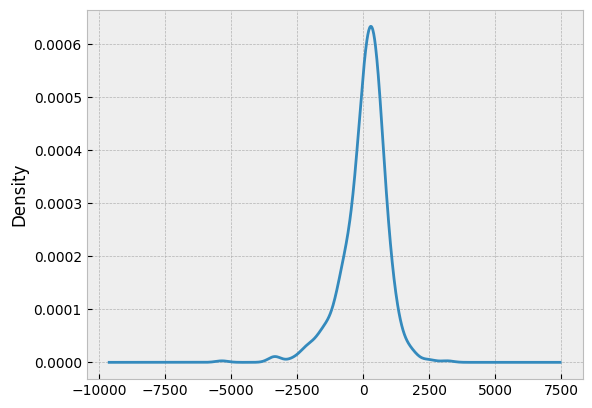

count     609.000000
mean       67.397781
std       843.582133
min     -5348.236864
25%      -272.525802
50%       181.680683
75%       554.012308
max      3193.122988
dtype: float64
Root Mean Square Error:845.5795364880554


In [226]:
plot_res(model.resid, 'residualse changes', 'Date', 'residuals')


As we see above, mean is not exactly zero that means there is some bias in the data.

In [227]:
train_month = df_month[:end_validation]
test_month = df_month[end_validation:]
model_m = ARIMA(train_month['users'].astype(float),
              order=(1, 1, 0),
              )
model_m = model_m.fit()
print(model_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  users   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -213.786
Date:                Wed, 05 Jul 2023   AIC                            431.572
Time:                        17:42:43   BIC                            433.460
Sample:                    01-31-2011   HQIC                           431.891
                         - 08-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4409      0.226      1.950      0.051      -0.002       0.884
sigma2      3.633e+08   2.15e-10   1.69e+18      0.000    3.63e+08    3.63e+08
Ljung-Box (L1) (Q):                   0.55   Jarque-

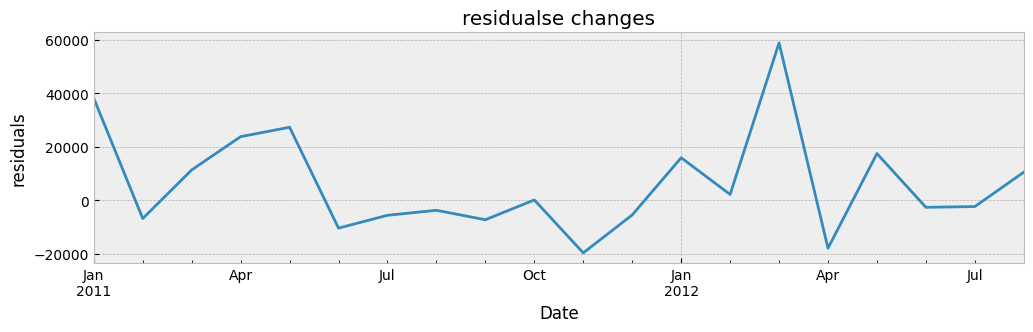

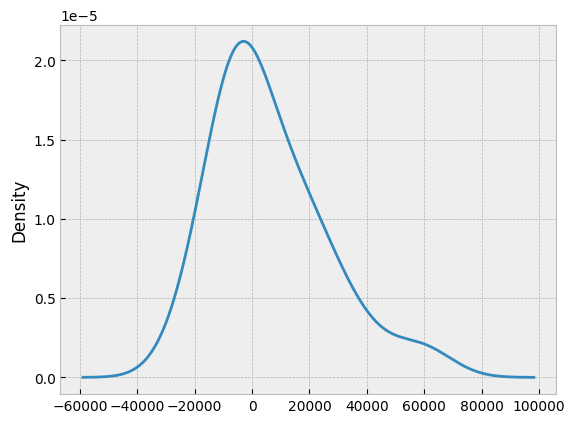

count       20.000000
mean      6238.843323
std      19564.862346
min     -19621.536842
25%      -5864.518463
50%      -1056.240726
75%      16353.746434
max      58919.544160
dtype: float64
Root Mean Square Error:20064.092621068598


In [228]:
plot_res(model_m.resid, 'residualse changes', 'Date', 'residuals')

##### Make Prediction on Test Set

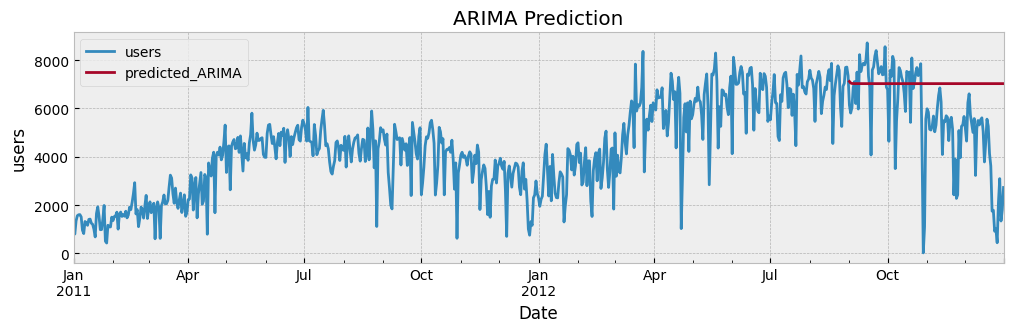

In [234]:
start= len(data_arima_train)
end= len(data_arima_train) + len(data_arima_test) - 1
pred = model.predict(start=start, end=end, type='levels', dynamic=True)
pred.index = data_arima.index[start:end+1]
data_arima['predicted_ARIMA'] = pred
plot_data(data=data_arima[['users','predicted_ARIMA']],
        title='ARIMA Prediction',
        xlabel='Date',
        ylabel='users')


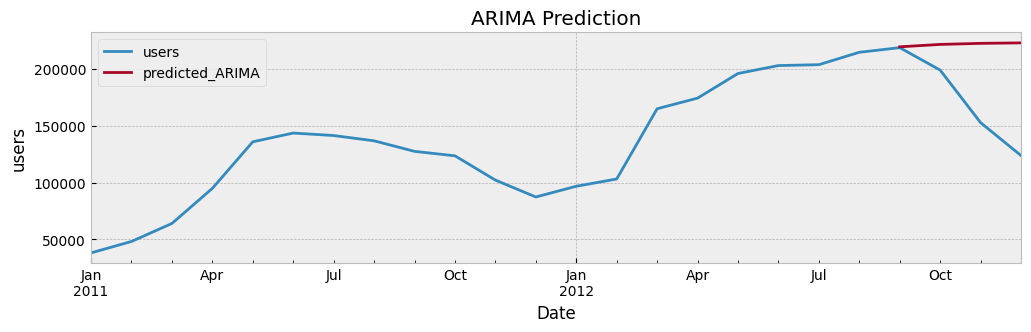

In [233]:
start= len(train_month)
end= len(train_month) + len(test_month) - 1
pred = model_m.predict(start=start, end=end, type='levels', dynamic=True)
pred.index = df_month.index[start:end+1]
df_month['predicted_ARIMA'] = pred
plot_data(data=df_month[['users','predicted_ARIMA']],
        title='ARIMA Prediction',
        xlabel='Date',
        ylabel='users')

If you observe the above, we are not getting good results using ARIMA because our data has seasonal behaviour, So let us try using seasonal ARIMA.

#####  Train the  Model - SARIMAX
- SARIMAX order (P, D, Q, m)
    - P: the order of the ‘Seasonal Auto Regressive’ (AR) term. <br>P = 1 if m > 0 and ACF and PACF plots both have their first significant lag at 1
    - D: the minimum number of ‘Seasonal differencing needed to make the series stationary. <br> D = d
    - Q: the order of the ‘‘Seasonal Moving Average’ (MA) term. <br>Q = 0 if m > 0 and ACF and PACF plots both have their first significant lag at 1
    - m: 
        - the number of time steps for a single seasonal period. <br>
        - identify this from the ACF and PACF plot where our value m is equal to the lag with the greatest autocorrelation coefficient.<br>
        - (seasonal length in the data) cuz greatest autocorrelation is at lag number 5

###### Grid Search

In [193]:
import itertools
#set parameter range
p = range(1,5)
d = range(1,2)
q = range(0,3)
s = range(1,5)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
# SARIMA model pipeline
min_AIC = 171745.338
bestParam = [int, int, int]
bestSParam = [int, int, int, int]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_month['users'].astype(float),
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min_AIC:
                min_AIC = results.aic
                bestParam = param
                bestSParam = param_seasonal
        except:
            continue
print(f"min_AIC:{min_AIC}, bestParam:{bestParam}, bestSParam:{bestSParam}")
# min_AIC:9743.914012001174, bestParam:(1, 1, 1), bestSParam:(1, 1, 1, 14) for daily data
# min_AIC:337.6102486050898, bestParam:(1, 1, 0), bestSParam:(4, 1, 0, 4) for monthly data

Optimization terminated successfully.
         Current function value: 9.742572
         Iterations: 2
         Function evaluations: 65
SARIMA(1, 1, 0),(1, 1, 0, 2) - AIC:395.70287095930377
Optimization terminated successfully.
         Current function value: 9.269631
         Iterations: 2
         Function evaluations: 69
SARIMA(1, 1, 0),(1, 1, 0, 3) - AIC:376.78522500216144
Optimization terminated successfully.
         Current function value: 8.642693
         Iterations: 2
         Function evaluations: 66
SARIMA(1, 1, 0),(1, 1, 0, 4) - AIC:351.70772419301096
Optimization terminated successfully.
         Current function value: 9.604662
         Iterations: 3
         Function evaluations: 134
SARIMA(1, 1, 0),(1, 1, 1, 2) - AIC:392.1864737489459
Optimization terminated successfully.
         Current function value: 9.144508
         Iterations: 4
         Function evaluations: 172
SARIMA(1, 1, 0),(1, 1, 1, 3) - AIC:373.7803039482882
Optimization terminated successfully.
       

###### After grid search

In [31]:
model2=sm.tsa.statespace.SARIMAX(data_arima_train['users'].astype(float),
                                 order=(1, 1, 1), # p, d, q
                                 seasonal_order=(1, 1, 1, 14), # P, D, Q, m
                                 ) 
model2 = model2.fit(disp=0, max_iter = 50, method = 'powell')
print(model2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              users   No. Observations:                  609
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 14)   Log Likelihood               -4866.957
Date:                            Tue, 04 Jul 2023   AIC                           9743.914
Time:                                    20:30:16   BIC                           9765.848
Sample:                                01-01-2011   HQIC                          9752.456
                                     - 08-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2672      0.046      5.799      0.000       0.177       0.358
ma.L1         -0.8971      0.020   

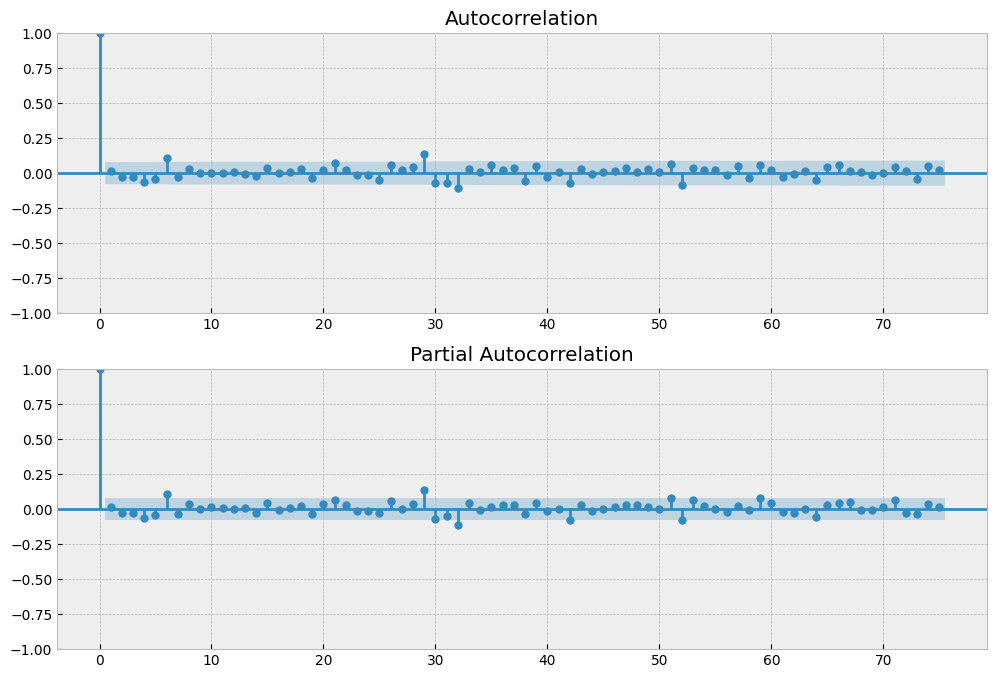

In [194]:
plot_acf_pacf(model2.resid, 75)

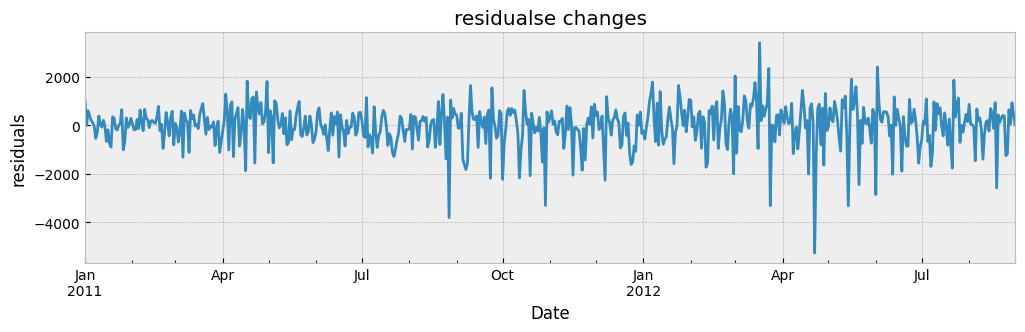

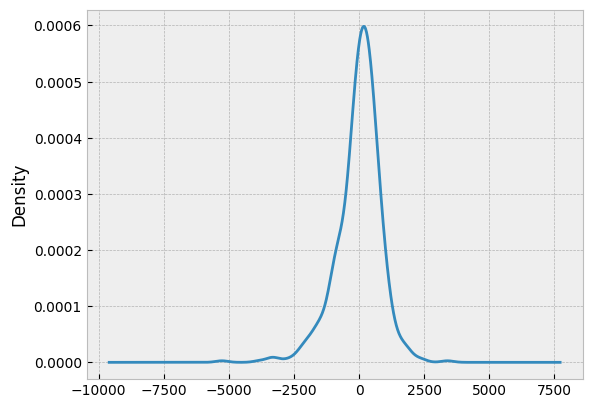

count     609.000000
mean      -15.399182
std       856.186068
min     -5268.686743
25%      -395.098154
50%        94.435299
75%       489.593964
max      3389.788695
dtype: float64
Root Mean Square Error:855.6214211303329


In [214]:
plot_res(model2.resid, 'residualse changes', 'Date', 'residuals')

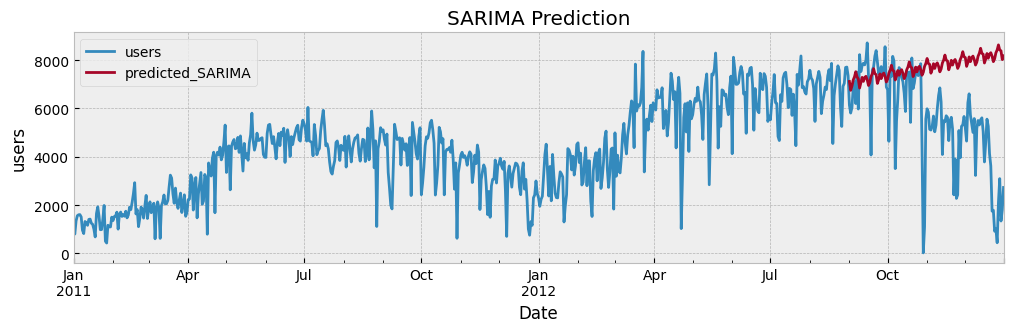

In [239]:
start= len(data_arima_train)
end= len(data_arima_train) + len(data_arima_test) - 1
pred = model2.predict(start=start, end=end, type='levels', dynamic=True)
pred.index = data_arima.index[start:end+1]
data_arima['predicted_SARIMA'] = pred
plot_data(data=data_arima[['users','predicted_SARIMA']],
        title='SARIMA Prediction',
        xlabel='Date',
        ylabel='users')


In [217]:
model2_m=sm.tsa.statespace.SARIMAX(train_month['users'].astype(float),
                                 order=(1, 1, 0), # p, d, q
                                 seasonal_order=(4, 1, 0, 4), # P, D, Q, m
                                 ) 
model2_m = model2_m.fit(disp=0, max_iter = 50, method = 'powell')
print(model2_m.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             users   No. Observations:                   20
Model:             SARIMAX(1, 1, 0)x(4, 1, 0, 4)   Log Likelihood                -162.805
Date:                           Wed, 05 Jul 2023   AIC                            337.610
Time:                                   17:40:09   BIC                            341.859
Sample:                               01-31-2011   HQIC                           337.565
                                    - 08-31-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3483      0.395      0.883      0.377      -0.425       1.122
ar.S.L4       -1.1773      0.060    -19.765

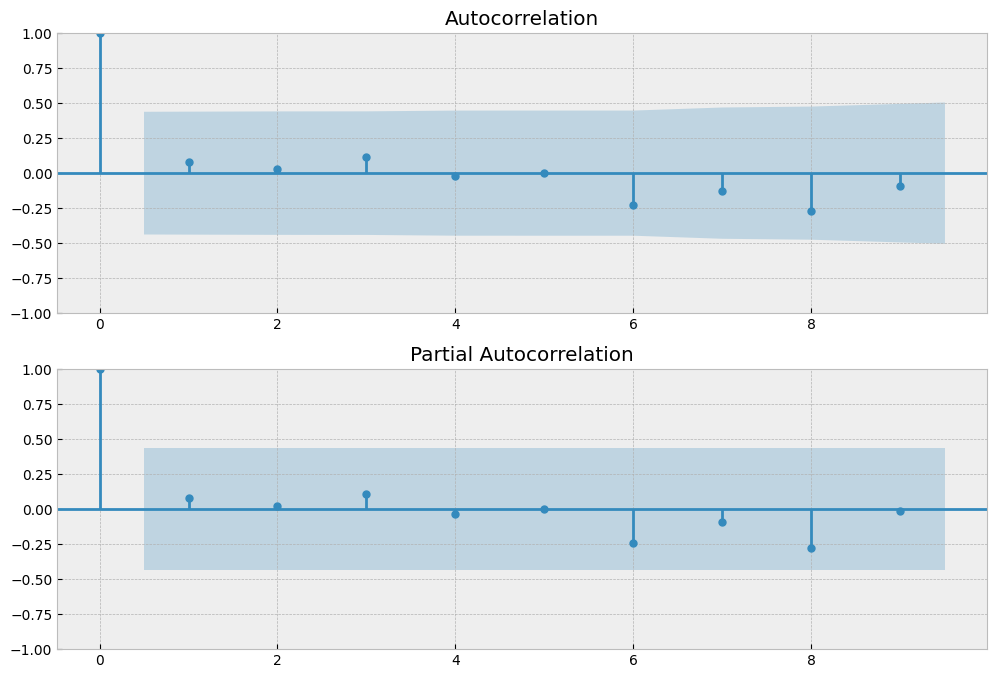

In [218]:
plot_acf_pacf(model2_m.resid, 9)

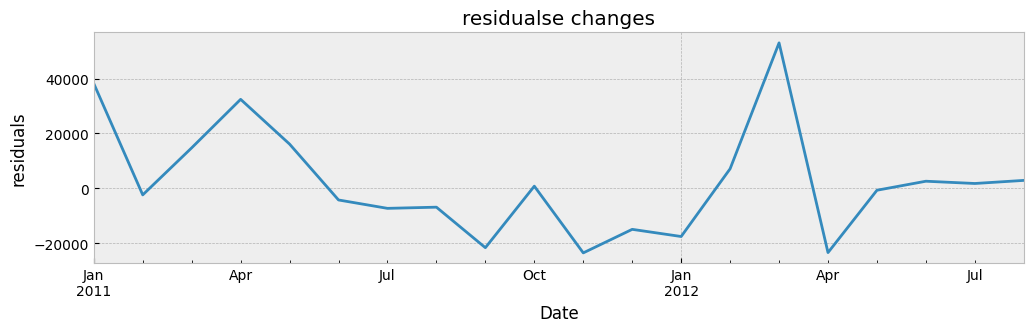

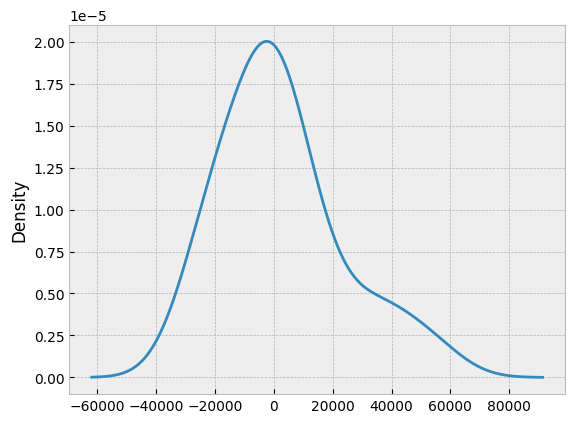

count       20.000000
mean      2335.091775
std      20511.382538
min     -23562.717937
25%      -9236.239615
50%         25.645241
75%       9019.279904
max      53024.549255
dtype: float64
Root Mean Square Error:20127.931501750987


In [219]:
plot_res(model2_m.resid, 'residualse changes', 'Date', 'residuals')

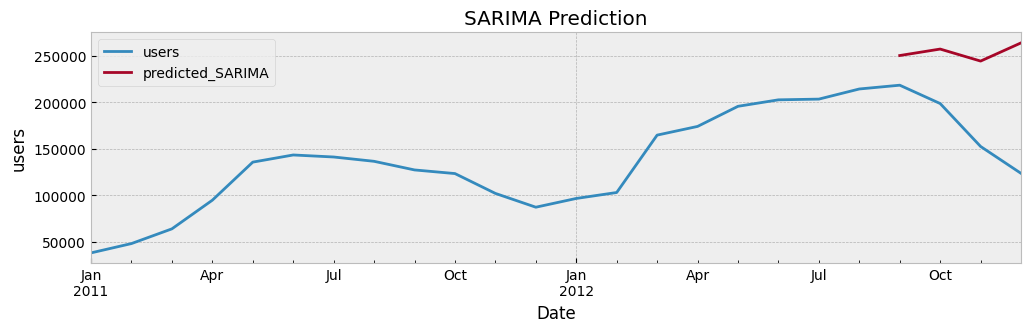

In [237]:
start= len(train_month)
end= len(train_month) + len(test_month) - 1
pred = model2_m.predict(start=start, end=end, type='levels', dynamic=True)
pred.index = df_month.index[start:end+1]
df_month['predicted_SARIMA'] = pred
plot_data(data=df_month[['users','predicted_SARIMA']],
        title='SARIMA Prediction',
        xlabel='Date',
        ylabel='users')


Conclusion: If you compare the ARIMA and SARIMA results, SARIMA gives good result comapre to ARIMA.

##### SARIMA with Exogenous features

In [39]:
data_arima_ex = pd.DataFrame(data = data_arima['users'])

# Adding of new exogenous features: PublicHoliday?, weather, weekday
data_arima_ex['holiday'] = data_arima['holiday']
data_arima_ex['weather'] = data_arima['weather']
data_arima_ex['weekday'] = data_arima['weekday']
# data_arima['hum'] = data_model['hum']

# One hot encoding of exogenous features
data_arima_ex = pd.get_dummies(data_arima_ex, columns=['holiday','weather', 'weekday'])
col_exog = [column for column in data_arima_ex.columns if column.startswith(('holiday','weather', 'weekday'))]
col_exog

['holiday_0',
 'holiday_1',
 'weather_clear',
 'weather_mist',
 'weather_rain',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [40]:
print(f"data shape: {data_arima_ex.shape}")
train = data_arima_ex.loc[: end_validation, :]
test = data_arima_ex.loc[end_validation:, :]
print(f"train shape:{train.shape}, test shape:{test.shape}")

data shape: (731, 13)
train shape:(609, 13), test shape:(122, 13)


In [41]:
# min_AIC:9743.914012001174, bestParam:(1, 1, 1), bestSParam:(1, 1, 1, 14)
model3 = sm.tsa.statespace.SARIMAX(train['users'].astype(float),
                                 exog = train[col_exog],
                                 order=(1, 1, 1),
                                 seasonal_order=(1, 1, 1, 14), # m = 5 according to ACF/PACF
                                 ) 
model3 = model3.fit(disp=0, max_iter = 50, method = 'powell')
print(model3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              users   No. Observations:                  609
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 14)   Log Likelihood               -4774.099
Date:                            Tue, 04 Jul 2023   AIC                           9582.199
Time:                                    20:34:05   BIC                           9656.776
Sample:                                01-01-2011   HQIC                          9611.243
                                     - 08-31-2012                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
holiday_0       179.6413   2608.894      0.069      0.945   -4933.698    5292.980
holiday_1        20.1009  

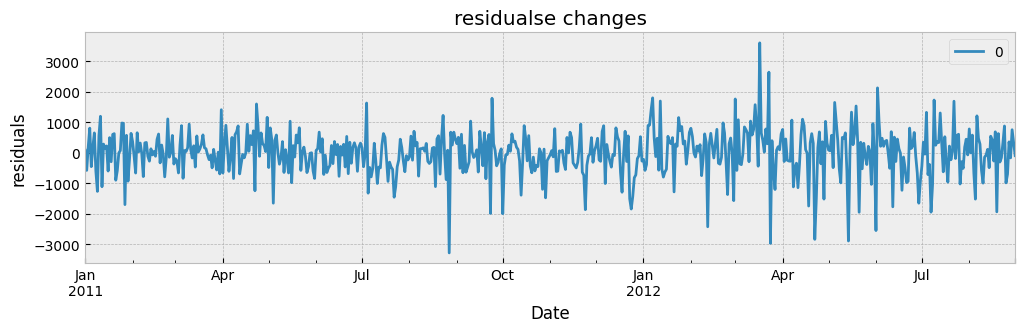

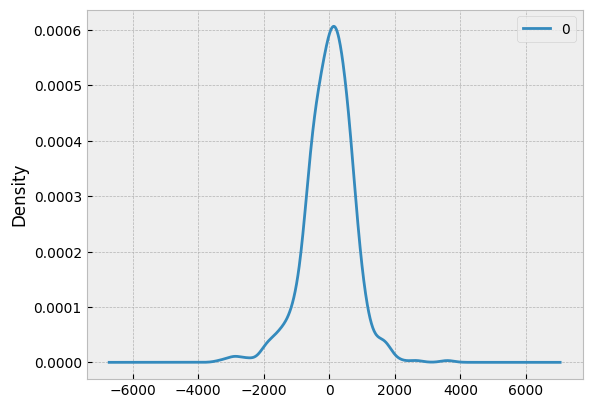

                 0
count   609.000000
mean     -4.113671
std     742.398526
min   -3276.604675
25%    -412.995100
50%      44.272553
75%     455.401218
max    3600.427494
Root Mean Square Error:0    741.800159
dtype: float64


In [42]:
residuals = pd.DataFrame(model3.resid)

plot_data(data=residuals,
          title='residualse changes',
          xlabel='Date',
          ylabel='residuals')

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())
print(f"Root Mean Square Error:{np.sqrt(np.mean(residuals**2))}")

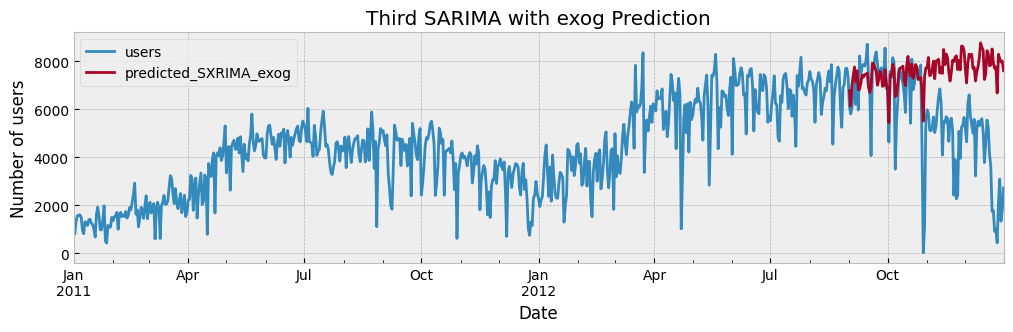

In [43]:
pred = model3.predict(exog = test[col_exog], 
                      start = len(train), 
                      end = len(train) + len(test) - 1, 
                      type = 'levels', 
                      dynamic = True)
pred.index = data_arima.index[start:end+1]
data_arima['predicted_SXRIMA_exog'] = pred

plot_data(data=data_arima[['users','predicted_SXRIMA_exog']],
          title='Third SARIMA with exog Prediction',
          xlabel='Date',
          ylabel='Number of users')


##### For Future Dates

In [50]:
end_train

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2013-06-21', '2013-06-22', '2013-06-23', '2013-06-24',
               '2013-06-25', '2013-06-26', '2013-06-27', '2013-06-28',
               '2013-06-29', '2013-06-30'],
              dtype='datetime64[ns]', length=181, freq='D')

In [81]:
data_arima['holiday'].loc['2011-01-01': '2011-06-30']

date_time
2011-01-01    0
2011-01-02    0
2011-01-03    0
2011-01-04    0
2011-01-05    0
             ..
2011-06-26    0
2011-06-27    0
2011-06-28    0
2011-06-29    0
2011-06-30    0
Freq: D, Name: holiday, Length: 181, dtype: int64

In [86]:
# Create Future data
future_datest_df=pd.DataFrame(index = index_future_dates_day,
                              columns = data_arima.columns)

# Adding exogenous features: holiday from 2011, weather from 2011, weekday
future_datest_df['holiday'] = data_arima['holiday'].loc['2011-01-01': '2011-06-30'].values
future_datest_df['weather'] = data_arima['weather'].loc['2011-01-01': '2011-06-30'].values
future_datest_df['weekday'] = future_datest_df.index.weekday
# print(future_datest_df)
future_df=pd.concat([data_arima,future_datest_df])

future_df_ex = pd.DataFrame(data = future_df[['users', 'holiday', 'weather', 'weekday']])
# One hot encoding of exogenous features
future_df_ex = pd.get_dummies(future_df_ex, columns=['holiday','weather', 'weekday'])
col_exog = [column for column in future_df_ex.columns if column.startswith(('holiday','weather', 'weekday'))]


###### prediction

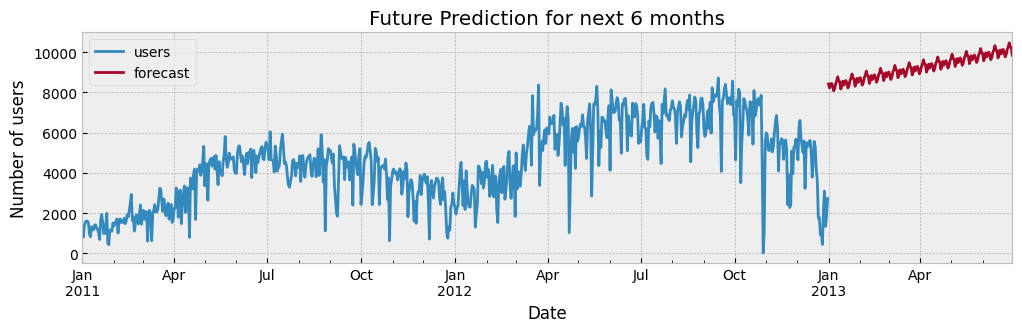

In [89]:
start = len(data_arima)
end = len(data_arima) + len(future_datest_df)
future_df_ex['forecast'] = model2.predict( 
                                        exog = future_df_ex[col_exog][start:end].astype(float),
                                        start = start,
                                        end = end - 1,
                                        type = 'levels',
                                        dynamic= True)

plt.style.use('bmh')
future_df_ex[['users', 'forecast']].plot(figsize=(12, 3)) 
plt.title('Future Prediction for next 6 months')
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.show()


In [92]:
print(future_df_ex['forecast'].tail(181))

2013-01-01     8413.873752
2013-01-02     8218.727116
2013-01-03     8387.455754
2013-01-04     8447.994743
2013-01-05     8305.061273
                  ...     
2013-06-26    10251.936317
2013-06-27    10457.789295
2013-06-28    10248.774772
2013-06-29    10213.161173
2013-06-30     9849.746546
Freq: D, Name: forecast, Length: 181, dtype: float64


### XGBoost

In [104]:
data_boost = df_hour.copy()
data_boost['datetime'] = data_boost.index
data_boost.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   holiday     17544 non-null  float64       
 1   workingday  17544 non-null  float64       
 2   weather     17544 non-null  object        
 3   temp        17544 non-null  float64       
 4   atemp       17544 non-null  float64       
 5   hum         17544 non-null  float64       
 6   windspeed   17544 non-null  float64       
 7   users       17544 non-null  float64       
 8   month       17544 non-null  int64         
 9   hour        17544 non-null  int64         
 10  weekday     17544 non-null  int64         
 11  datetime    17544 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 2.2+ MB


##### split data to test-67%, validation-20%, and test-13%

In [96]:
# Interactive plot of time series
# ==============================================================================
data_boost.loc[:end_train, 'partition'] = 'train'
data_boost.loc[end_train:end_validation, 'partition'] = 'validation'
data_boost.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data_boost.reset_index(),
    x      = 'datetime',
    y      = 'users',
    color  = 'partition',
    title  = 'Number of Users',
    width  = 1000,
    height = 450
)
fig.update_layout(
    width  = 1000,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()
data_tune=data_boost.drop(columns='partition')

#### Train the Model - XGBoost
XGBoost is a highly efficient implementation of the stochastic gradient boosting algorithm, which has become a benchmark in the field of machine learning. The XGBoost library includes its own API as well as the XGBRegressor class, which follows the scikit-learn API, making it compatible with skforecast.

First, an autoregressive model is trained using past values (lags) of the response variable as predictors. Later, exogenous variables are added to the model and the improvement in its performance is assessed.

Gradient Boosting models have a large number of hyperparameters, so a combination of grid_search strategy and backtesting is used to identify the best configuration that gives the most accurate predictions.



In [97]:
# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags = 14
                 # The lag parameter determines how many previous time steps are considered when making predictions.
                 # For example, if the lag is set to 3, the model will use the past three observations to predict the next value.
                 # If the lag is too small, the model may overlook important information, resulting in poor predictions. 
                 # On the other hand, if the lag is too large, the model might incorporate excessive noise or irrelevant data, leading to overfitting or decreased forecasting accuracy.
             )

##### Hyperparameter tuning
- To avoid overfitting, a search is performed where each combination of hyperparameters and lags is tested as follows:
    - Train the model using only the training set.
    - The model is evaluated using the validation set via backtesting.
    - The combination of hyperparameters and lags that gives the lowest error is selected.
    - Train the model again using the best combination found, this time using both the training and validation data.

In [98]:
def custom_metric(y_true, y_pred):
    '''
    RMSE
    '''
    metric = mean_squared_error(y_true, y_pred, squared= False)
    return metric

In [105]:
# Grid search of hyperparameters and lags
# Regressor hyperparameters
param_grid = {
    'n_estimators': [10, 500], # refers to the number of individual regression trees, higher number higher complisity
    'max_depth': [3, 5, 10], # larger number, more plits, more complex interactions between features
    'learning_rate': [0.0001, 0.1] # controls the step size at which the boosting algorithm learns from each tree, smaller number, smaller updates, more conservative learning process
}

# Lags used as predictors
lags_grid = [1, 29]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_boost.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 14,
                   refit              = False,
                   metric             = custom_metric,
                   initial_train_size = len(data_train_hour), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False,
               )
results_grid.head()

Number of models compared: 24.


lags grid: 100%|██████████| 2/2 [02:16<00:00, 68.29s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 102.84592385192211



,lags,params,custom_metric,learning_rate,max_depth,n_estimators
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",102.845924,0.1,3.0,500.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",103.928155,0.1,5.0,500.0
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",109.020282,0.1,10.0,500.0
7,[1],"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",249.391305,0.1,3.0,500.0
11,[1],"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",252.634912,0.1,10.0,500.0


In [106]:
# Extract feature importances
importance = forecaster.get_feature_importances()
importance

,feature,importance
0,lag_1,0.380776
1,lag_2,0.011102
2,lag_3,0.070002
3,lag_4,0.028075
4,lag_5,0.007679
5,lag_6,0.020949
6,lag_7,0.010873
7,lag_8,0.004435
8,lag_9,0.033368
9,lag_10,0.036115


Since return_best = True, the forecaster object will be updated with the best configuration found and trained on the entire dataset. This means that the final model obtained from the grid search will have the best combination of lags and hyperparameters that resulted in the highest performance metric. This final model can then be used for future predictions on new data.

##### Backtesting test period
Once the best combination of hyperparameters has been identified using the validation data, the predictive capacity of the model is evaluated when applied to the test set. The backtesting_forecaster function is used to simulate the prediction process every 30 days.

It is recommended to review the documentation for the backtesting_forecaster function to gain a better understanding of its capabilities. This will help to utilize its full potential to analyze the predictive capacity of the model.


In [107]:
# Backtesting on test data
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data_boost['users'],
                            initial_train_size = len(data_tune.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps              = 14,
                            refit              = False,
                            metric             = custom_metric,
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest error: {metric:.2f}")
predictions

100%|██████████| 210/210 [00:02<00:00, 98.72it/s] 

Backtest error: 100.36


,pred
2012-09-01 00:00:00,100.241875
2012-09-01 01:00:00,73.348061
2012-09-01 02:00:00,42.812107
2012-09-01 03:00:00,18.976410
2012-09-01 04:00:00,4.154464
...,...
2012-12-31 19:00:00,125.022636
2012-12-31 20:00:00,90.874832
2012-12-31 21:00:00,69.408478
2012-12-31 22:00:00,72.701515


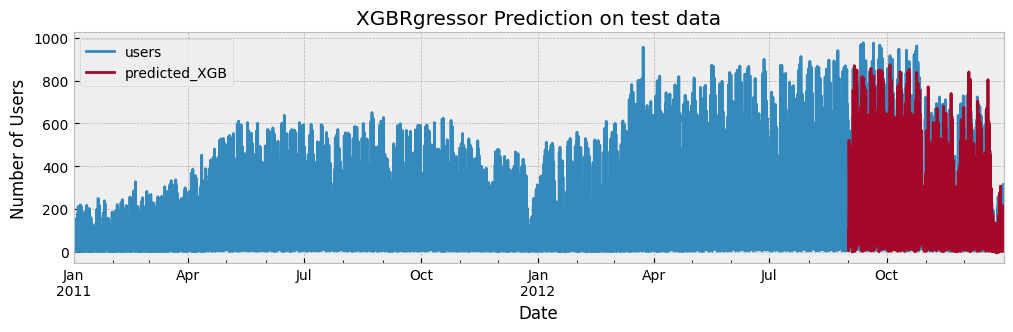

In [108]:
# plot the prediction

data_boost['predicted_XGB'] = predictions
plot_data(data=data_boost[['users','predicted_XGB']],
          title='XGBRgressor Prediction on test data',
          xlabel='Date',
          ylabel='Number of Users')

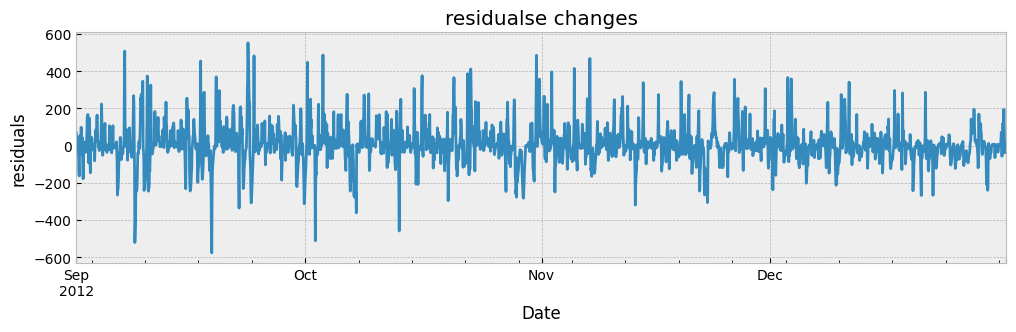

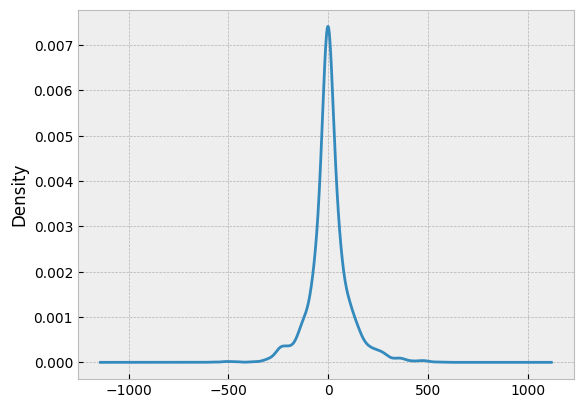

count    2928.000000
mean        4.301421
std       100.281959
min      -576.552185
25%       -35.606758
50%        -0.353417
75%        39.920199
max       551.608246
dtype: float64
Root Mean Square Error:100.35705748218672


In [109]:
residuals = data_test_hour['users'] - predictions['pred']

# plot the residuals
plot_data(data=residuals,
          title='residualse changes',
          xlabel='Date',
          ylabel='residuals')

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())
print(f"Root Mean Square Error:{np.sqrt(np.mean(residuals**2))}")

#### Train the XGBoost with Exogenous features¶
In addition to using autoregressive predictors obtained from the past of the response variable itself, it is possible to add other exogenous variables. <br>
In this case, 
- calendar information (month, day of the week, time, holidays, ...) and 
- weather variables (wind, temperature, humidity, ...) are available.

In [110]:
data_exog = df_hour.copy()
data_exog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     17544 non-null  float64
 1   workingday  17544 non-null  float64
 2   weather     17544 non-null  object 
 3   temp        17544 non-null  float64
 4   atemp       17544 non-null  float64
 5   hum         17544 non-null  float64
 6   windspeed   17544 non-null  float64
 7   users       17544 non-null  float64
 8   month       17544 non-null  int64  
 9   hour        17544 non-null  int64  
 10  weekday     17544 non-null  int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 2.1+ MB


One hot encoding<br>
ColumnTransformers in scikit-learn provide a powerful way to define transformations and apply them to specific features. By encapsulating the transformations in a ColumnTransformer object, it can be passed to a forecaster using the transformer_exog argument.
> Note <br>
Applying a transformation to the entire dataset independent of the forecaster is feasible. However, it is crucial to ensure that the transformations are learned only from the training data to avoid information leakage. In addition, the same transformation should be applied to the input data during prediction. Therefore, it is advisable to include the transformation in the forecaster, so that it is handled internally. This approach ensures consistency in the application of transformations and reduces the likelihood of errors.

In [140]:
# One hot encoding transformer
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, 
                                        drop='if_binary', 
                                        handle_unknown='ignore'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [141]:
# Create forecaster with a transformer for exogenous features
forecaster = ForecasterAutoreg(
                 regressor        = XGBRegressor(random_state=123),
                 lags             = 14,
                 transformer_exog = one_hot_encoder
             )

>To examine how the data is transformed, it is possible to use the create_train_X_y method to generate the matrices that the forecaster uses to train the model.<br> This approach provides insight into the specific data manipulations that occur during the training process.

In [142]:
data_exog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     17544 non-null  float64
 1   workingday  17544 non-null  float64
 2   weather     17544 non-null  object 
 3   temp        17544 non-null  float64
 4   atemp       17544 non-null  float64
 5   hum         17544 non-null  float64
 6   windspeed   17544 non-null  float64
 7   users       17544 non-null  float64
 8   month       17544 non-null  int64  
 9   hour        17544 non-null  int64  
 10  weekday     17544 non-null  int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 2.1+ MB


In [143]:
# View Training Matrix

exog_features = [
                 'holiday', 
                 'weather', 
                 'weekday', 
                #  'LeaveNum',
                #  'HomeNum',
                #  'temp', 
                 ]
                 
X_train, y_train = forecaster.create_train_X_y(
                        y = data_exog.loc[:end_validation, 'users'],
                        exog = data_exog.loc[:end_validation, exog_features]
                   )

In [144]:
# Grid search of hyperparameters and lags

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_exog.loc[:end_validation, 'users'],
                   exog               = data_exog.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 14,
                   refit              = False,
                   metric             = custom_metric,
                   initial_train_size = len(data_exog.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False,
               )

Number of models compared: 24.


lags grid: 100%|██████████| 2/2 [03:00<00:00, 90.08s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 89.63174190553879



In [145]:
# Backtesting test data
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data_exog['users'],
                          exog               = data_exog[exog_features],
                          initial_train_size = len(data_exog.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 14,
                          refit              = False,
                          metric             = custom_metric,
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

100%|██████████| 210/210 [00:03<00:00, 69.86it/s]


Backtest error: 83.09


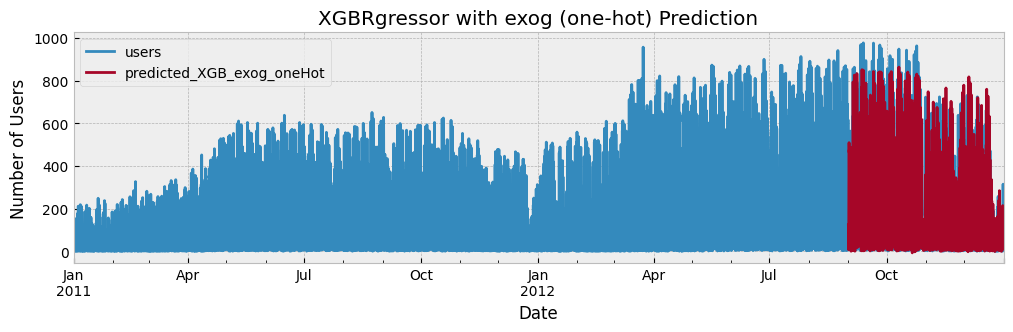

In [146]:
# plot the prediction
data_boost['predicted_XGB_exog_oneHot'] = predictions
plot_data(data=data_boost[['users','predicted_XGB_exog_oneHot']],
          title='XGBRgressor with exog (one-hot) Prediction',
          xlabel='Date',
          ylabel='Number of Users')

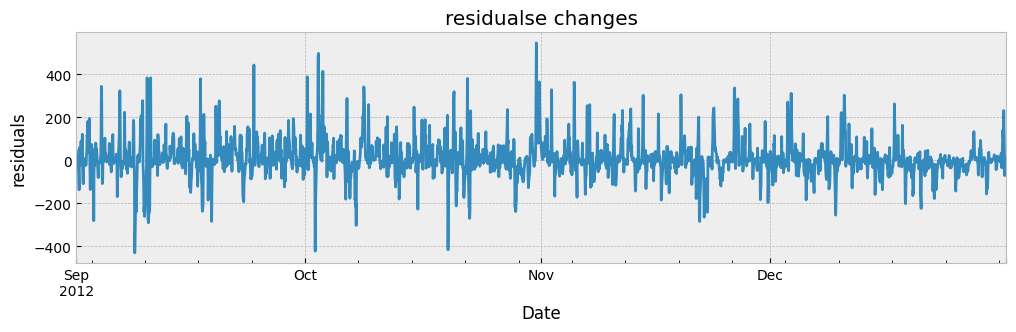

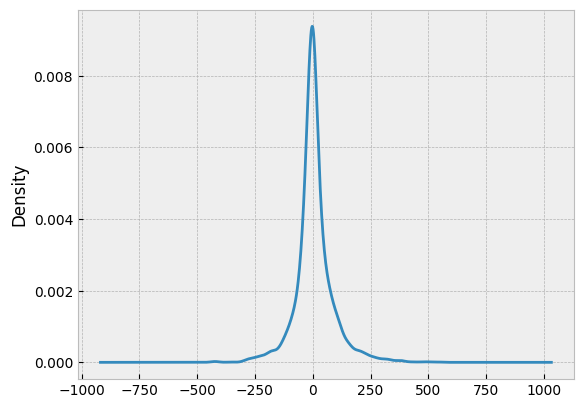

count    2928.000000
mean        6.699306
std        82.829836
min      -430.716858
25%       -25.464458
50%        -0.063481
75%        34.091059
max       544.821625
dtype: float64
Root Mean Square Error:83.08621608915693


In [147]:
residuals = data_test_hour['users'] - predictions['pred']

# plot the residuals
plot_data(data=residuals,
          title='residualse changes',
          xlabel='Date',
          ylabel='residuals')

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())
print(f"Root Mean Square Error:{np.sqrt(np.mean(residuals**2))}")

#### Final Model

In [148]:
# Create Future data
future_datest_df=pd.DataFrame(index = index_future_dates_hour,
                              columns = data_exog.columns)
# Adding exogenous features: holiday from 2011, weather from 2011, weekday
future_datest_df['holiday'] = data_exog['holiday'].loc['2011-01-01 00:00:00': '2011-06-30 23:59:00'].values
future_datest_df['weather'] = data_exog['weather'].loc['2011-01-01 00:00:00': '2011-06-30 23:59:00'].values
future_datest_df['weekday'] = future_datest_df.index.weekday

# print(future_datest_df)
future_df=pd.concat([data_exog,future_datest_df])
future_df.tail(5)

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
2013-06-30 19:00:00,0.0,NaN,clear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2013-06-30 20:00:00,0.0,NaN,clear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2013-06-30 21:00:00,0.0,NaN,clear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2013-06-30 22:00:00,0.0,NaN,clear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2013-06-30 23:00:00,0.0,NaN,clear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


In [149]:
end_last = '2012-12-31 23:59:00'
future_df['forecast_XGB_exog'] = forecaster.predict(
                                 steps = len(index_future_dates_hour),
                                 last_window = future_df.loc[:end_last, 'users'],         
                                 exog = future_df.loc[end_last:, exog_features] 
                                 )


In [150]:
future_df['forecast_XGB_exog'].tail(len(index_future_dates_hour))

2013-01-01 00:00:00     31.125580
2013-01-01 01:00:00     16.882538
2013-01-01 02:00:00      9.991905
2013-01-01 03:00:00      3.748708
2013-01-01 04:00:00      5.489346
                          ...    
2013-06-30 19:00:00    281.356262
2013-06-30 20:00:00    322.362915
2013-06-30 21:00:00    348.459625
2013-06-30 22:00:00    365.346741
2013-06-30 23:00:00    383.767853
Freq: H, Name: forecast_XGB_exog, Length: 4344, dtype: float64

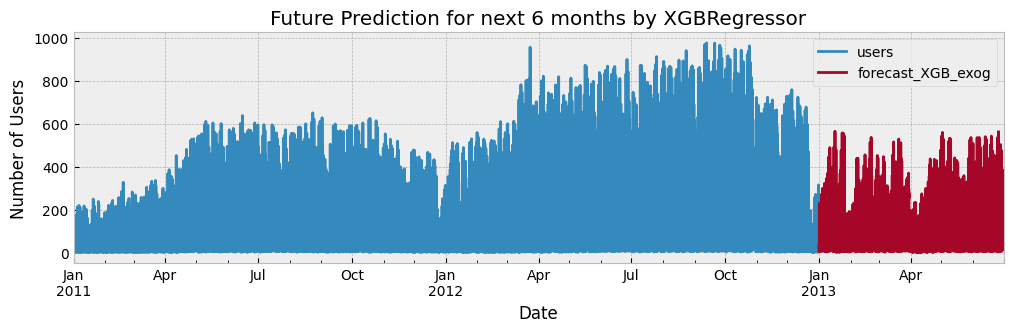

In [151]:
# feature prediction
# ForecasterAutoreg.predict(steps, last_window=None, exog=None)
plt.style.use('bmh')
future_df[['users', 'forecast_XGB_exog']].plot(figsize=(12, 3)) 
plt.title('Future Prediction for next 6 months by XGBRegressor')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.show()
